In [14]:
import xarray
data = xarray.open_dataset("/homes/starrgw1/code/gnss-tid/multirun/2024-11-21/15-41-33/0/autofocus.h5")

<xarray.Dataset> Size: 1GB
Dimensions:     (x: 453, y: 290, time: 239, py: 17, px: 27, ky: 32, kx: 32)
Coordinates:
  * x           (x) float64 4kB -2.194e+03 -2.184e+03 ... 2.311e+03 2.321e+03
  * y           (y) float64 2kB -1.284e+03 -1.274e+03 ... 1.591e+03 1.601e+03
  * time        (time) datetime64[ns] 2kB 2015-03-25T22:00:00 ... 2015-03-26T...
  * kx          (kx) float64 256B 0.0 0.003125 0.00625 ... -0.00625 -0.003125
  * ky          (ky) float64 256B 0.0 0.003125 0.00625 ... -0.00625 -0.003125
  * px          (px) float64 216B -2.034e+03 -1.874e+03 ... 1.961e+03 2.121e+03
  * py          (py) float64 136B -1.124e+03 -964.3 ... 1.272e+03 1.431e+03
Data variables:
    image       (time, y, x) float64 251MB ...
    patch       (time, py, px, ky, kx) float64 899MB ...
    Fx          (time, py, px) float64 878kB ...
    Fy          (time, py, px) float64 878kB ...
    F           (time, py, px) float64 878kB ...
    height      (time) float64 2kB ...
    n           (time) float64 2kB ...
    objective   (time) float64 2kB ...
    cx          (time) float64 2kB ...
    cy          (time) float64 2kB ...
    wavelength  (time) float64 2kB ...
    offset      (time) float64 2kB ...
Attributes:
    coord_center:  [ 36.  -97.5]

In [77]:
import numpy as np
t = np.unwrap(data.time.dt.hour, period=24) + data.time.dt.minute / 60
mask = abs(t - 24) > .5
# data.isel(time=mask).plot.scatter(x="cx", y="cy", hue="height")
# data.isel(time=mask).height.plot()
data.x

<xarray.DataArray 'x' (x: 453)> Size: 4kB
array([-2194.019999, -2184.031782, -2174.043564, ...,  2300.677913,
        2310.666131,  2320.654348])
Coordinates:
  * x        (x) float64 4kB -2.194e+03 -2.184e+03 ... 2.311e+03 2.321e+03

In [1]:
import logging
import hydra
from matplotlib import pyplot as plt
from scipy.fft import fft2
import numpy as np
from joblib import Parallel, delayed
import xarray
from gnss_tid.plotting import plot_patches, plot_circles

with hydra.initialize(version_base=None, config_path="src/gnss_tid/conf", job_name="jupyter"):
    cfg = hydra.compose(config_name="config")
logging.basicConfig(level=logging.INFO)

# cfg.focus.image_maker.hres = 10
# cfg.focus.block_size = 64
# cfg.focus.block_step = 16
cfg.focus.height_step = 40
logging.info("%s", cfg.focus.n_jobs)
points = hydra.utils.instantiate(cfg.event.pointdata)
focuser = hydra.utils.instantiate(cfg.focus)
data = focuser.run(points, cfg.sample.window, cfg.sample.step)

INFO:root:1
INFO:gnss_tid.spectral:running initializer
INFO:gnss_tid.spectral:initializer finished, best slice -> 1: 10770
INFO:gnss_tid.image:image boundary west: -2202.38
INFO:gnss_tid.image:image boundary south: -1369.76
INFO:gnss_tid.image:image boundary east: 2348.54
INFO:gnss_tid.image:image boundary north: 1606.04
INFO:gnss_tid.spectral:running BlockSpectralProcessing
INFO:gnss_tid.spectral:[000-004]: processing heights
INFO:gnss_tid.spectral:[000-004]: height = 160.0
INFO:gnss_tid.spectral:[000-004]: height = 200.0
INFO:gnss_tid.spectral:[000-004]: height = 240.0
INFO:gnss_tid.spectral:[000-004]: height = 280.0
INFO:gnss_tid.spectral:[000-004]: height = 320.0
INFO:gnss_tid.spectral:[000-004]: height = 360.0
INFO:gnss_tid.spectral:[000-004]: processing patches
INFO:gnss_tid.spectral:[000-004]: finding params
INFO:gnss_tid.spectral:[000-004]: params fit in 133 iterations
INFO:gnss_tid.spectral:[000-004]: SUCCESS
INFO:gnss_tid.spectral:[002-006]: processing heights
INFO:gnss_tid.s

In [2]:
result = focuser.run_center_finder(points, data.isel(time=0), slice(0, 4))

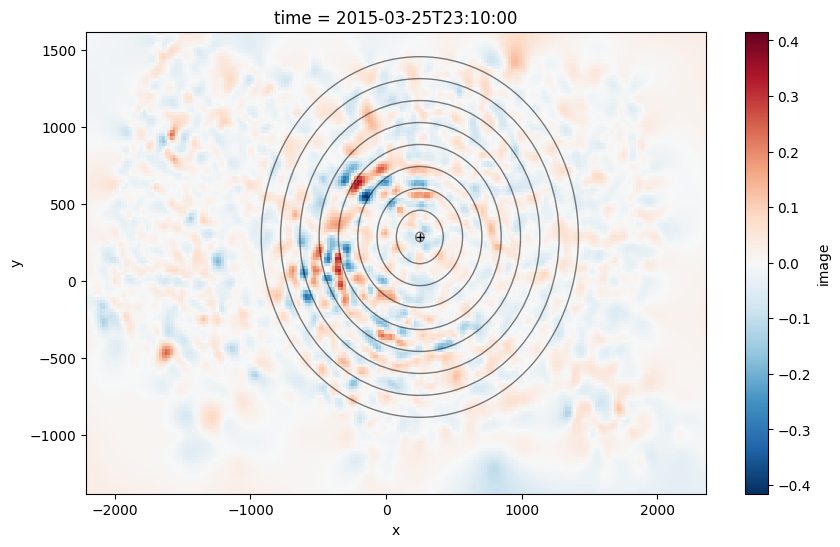

In [13]:
center = [data.isel(time=0).cx.values, data.isel(time=0).cy.values]
wavelength = data.isel(time=0).wavelength.values
offset = data.isel(time=0).offset.values

fig, ax = plt.subplots(1, figsize=(10, 6))
p = points.get_data(slice(0, 4), data.isel(time=0).height.item())
data.isel(time=0).image.plot(ax=ax)
plot_circles(center, wavelength, offset, ax=ax)

(400.0, 1000.0)

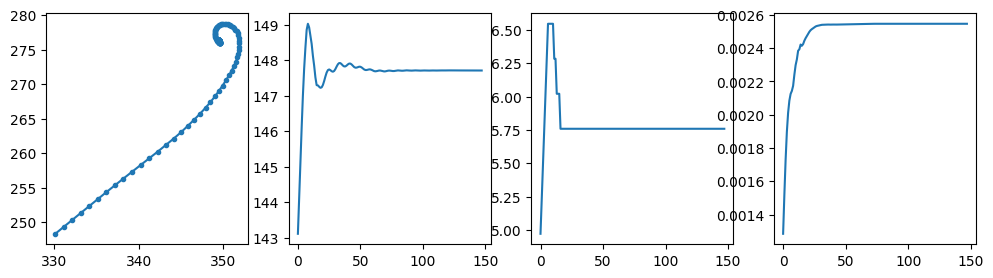

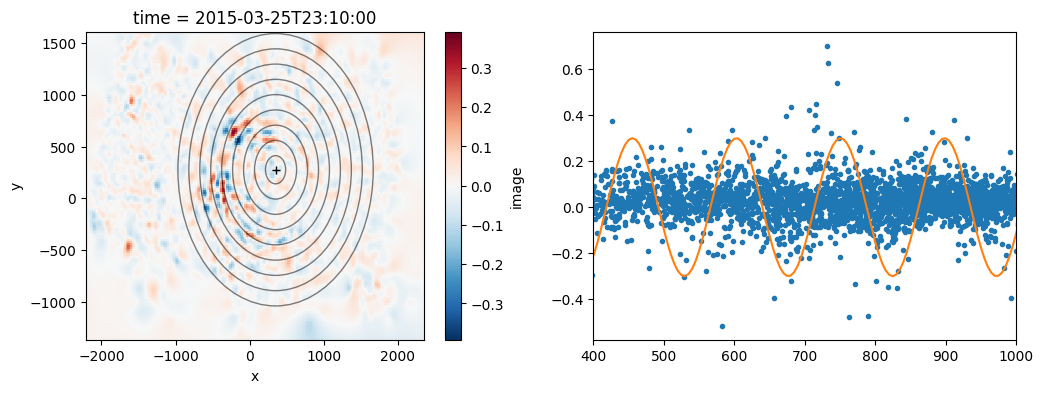

In [4]:

fig, ax = plt.subplots(1, 4, figsize=(12, 3))
z = np.array(result["history"]["center"])
ax[0].plot(z[:, 0], z[:, 1], '.-')
ax[1].plot(result["history"]["wavelength"])
ax[2].plot(np.unwrap(result["history"]["phase"]))
ax[3].plot(result["history"]["metric"])

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
p = points.get_data(slice(0, 4), data.isel(time=0).height.item())
data.isel(time=0).image.plot(ax=ax[0])
plot_circles(result["center"], result["wavelength"], result["offset"], ax=ax[0])

r = np.hypot(p.x.values - result["center"][0], p.y.values - result["center"][1])
ax[1].plot(r, p.tec, '.')
rp = np.arange(0, r.max(), 5)
tp = np.cos(2*np.pi*(rp + result["offset"])/result["wavelength"]) * .3
ax[1].plot(rp, tp)
ax[1].set_xlim(400, 1000)


[183.40000726 400.22960846] [281.19436913 287.85620487] [332.56588637 188.04107951]


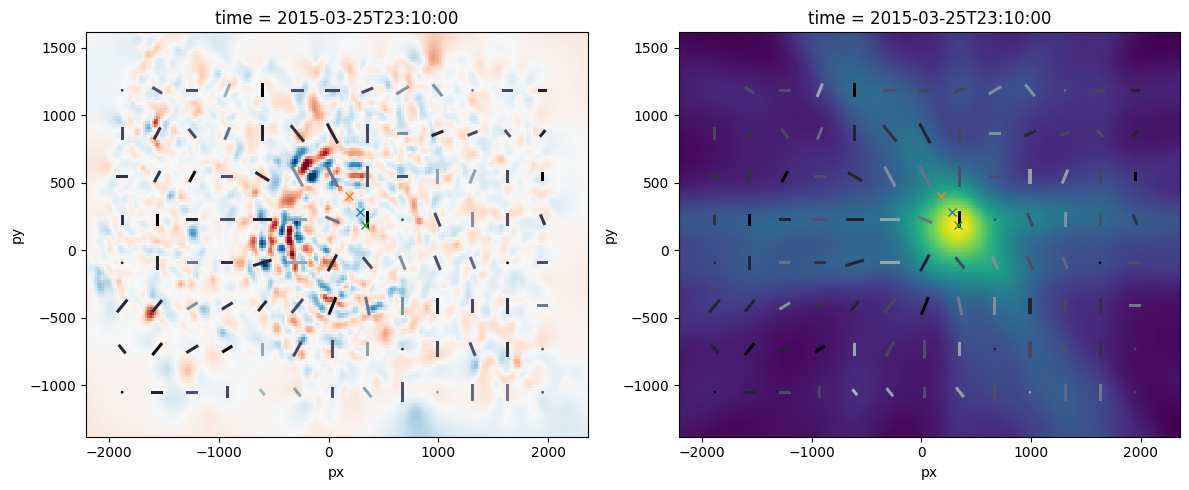

In [2]:
import numpy as np

def find_center(pts, vectors, weights):
    vec_norm = np.linalg.norm(vectors, axis=1)
    mask = vec_norm > 0
    w = np.sqrt(weights[mask]) / vec_norm[mask]
    A = np.column_stack([vectors[mask, 1], -vectors[mask, 0]]) * w[:, None]
    b = np.sum(A * pts[mask], axis=1)
    center, *_ = np.linalg.lstsq(A, b)
    return center

def get_distances(pts, vectors, weights, tp):
    vec_norm = np.linalg.norm(vectors, axis=1)
    mask = vec_norm > 0
    x = tp[:, 0][:, None]
    y = tp[:, 1][:, None]
    x1 = pts[mask, 0][None, :]
    y1 = pts[mask, 1][None, :]
    vx = vectors[mask, 0][None, :]
    vy = vectors[mask, 1][None, :]
    # Numerator: |vx * (y - y1) - vy * (x - x1)|
    numerator = np.abs(vx * (y - y1) - vy * (x - x1))
    # Denominator: sqrt(vx^2 + vy^2)
    denominator = np.sqrt(vx**2 + vy**2)
    # Distance matrix: D[i, j]
    distances = numerator / denominator
    return np.sum(weights[None, mask] * np.exp(-(distances/200)**2), axis=1)
    # return np.sum(weights[None, mask] * distances**2, axis=1)

X, Y = np.meshgrid(data.px.values, data.py.values)
pts = np.column_stack([X.ravel(), Y.ravel()])
weights = data.F.isel(time=0).values.ravel()
vectors = np.column_stack((data.Fx.isel(time=0).values.ravel(), data.Fy.isel(time=0).values.ravel()))
cw = find_center(pts, vectors, weights)
cu = find_center(pts, vectors, np.ones_like(weights))
x, y = np.meshgrid(data.x.values, data.y.values)
xy = np.column_stack([x.ravel(), y.ravel()])
dw = get_distances(pts, vectors, weights, xy).reshape(x.shape)
cg = xy[np.argmax(dw)]

fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 5))
plot_patches(data.isel(time=0), ax=ax[0], img=True)
ax[0].plot(cw[0], cw[1], 'x')
ax[0].plot(cu[0], cu[1], 'x')
ax[0].plot(cg[0], cg[1], 'x')
ax[1].pcolormesh(x, y, dw)
ax[1].plot(cw[0], cw[1], 'x')
ax[1].plot(cu[0], cu[1], 'x')
ax[1].plot(cg[0], cg[1], 'x')
plot_patches(data.isel(time=0), ax=ax[1], img=False)
print(cu, cw, cg)

height = 250
height = 275


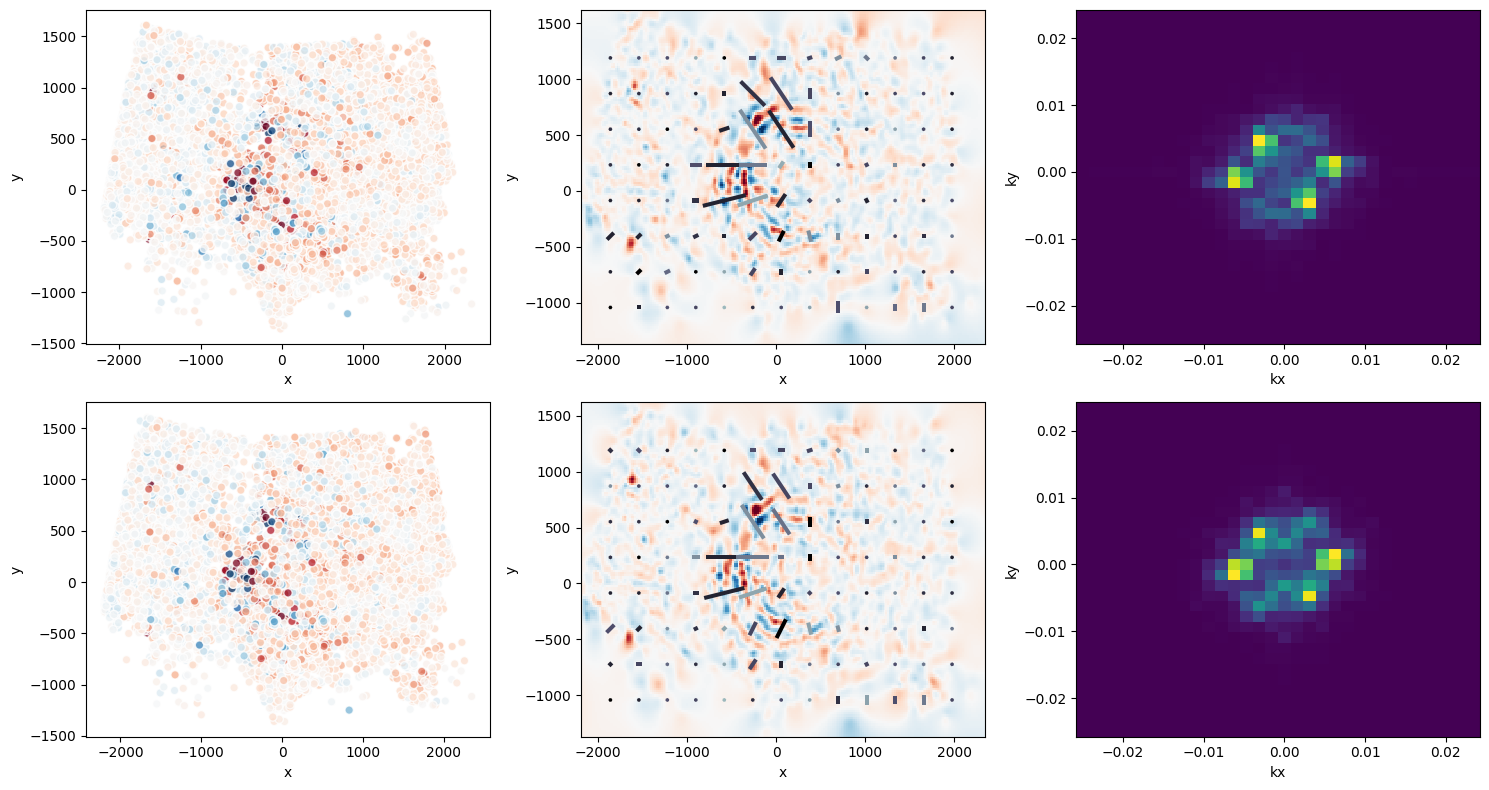

In [27]:
nrows = focuser.heights.shape[0]
if nrows <= 8:
    fig, ax = plt.subplots(nrows, 3, figsize=(15, 4 * nrows), tight_layout=True)
    ax = ax.reshape((nrows, 3))
    B = []
    F = []
    for i, height in enumerate(focuser.heights):
        data = points.get_data(slice(4), height)
        print(f"height = {height}")
        img = focuser.image_maker(data.x.values, data.y.values, data.tec.values)
        patches = focuser.get_fft_patches(img)
        kmax = patches.isel(patches.argmax(dim=["x", "y"])).sortby(["kx", "ky"])
        patchmax = patches.isel(patches.argmax(dim=["kx", "ky"]))
        kmag = np.hypot(patchmax.kx, patchmax.ky)
        kscale = patchmax / kmag.where(lambda x: x > 0, 1)
        ds = xarray.Dataset({
            "F": patchmax,
            "k": kmag,
            "vx": patchmax.kx * kscale,
            "vy": patchmax.ky * kscale,
        }).reset_coords()
        data.plot.scatter(ax=ax[i, 0], x="x", y="y", hue="tec", vmax=.3, alpha=.75, add_colorbar=False)
        # image
        img.plot(ax=ax[i, 1], vmax=.3, add_colorbar=False)
        # directions
        ds.plot.quiver(
            x="x", y="y", u="vx", v="vy", hue="k", ax=ax[i, 1], cmap="bone",
            headwidth=0, headlength=0, headaxislength=0, add_guide=False, 
            scale=5000, width=.01, vmin=0, vmax=.01
        )
        # focus
        kmax.plot(ax=ax[i, 2], add_colorbar=False)
        B.append(patches)
else:
    data = points.get_data(slice(4), focuser.heights[3])
    focuser.image_maker.initialize(data.x.values, data.y.values)
    @delayed
    def func(height):
        data = points.get_data(slice(4), height)
        img = focuser.image_maker(data.x.values, data.y.values, data.tec.values)
        patches = focuser.get_fft_patches(img)
        return patches
    with Parallel(n_jobs=16, verbose=50) as pool:
        B = pool(func(h) for h in focuser.heights)

B = np.stack(B, axis=0)

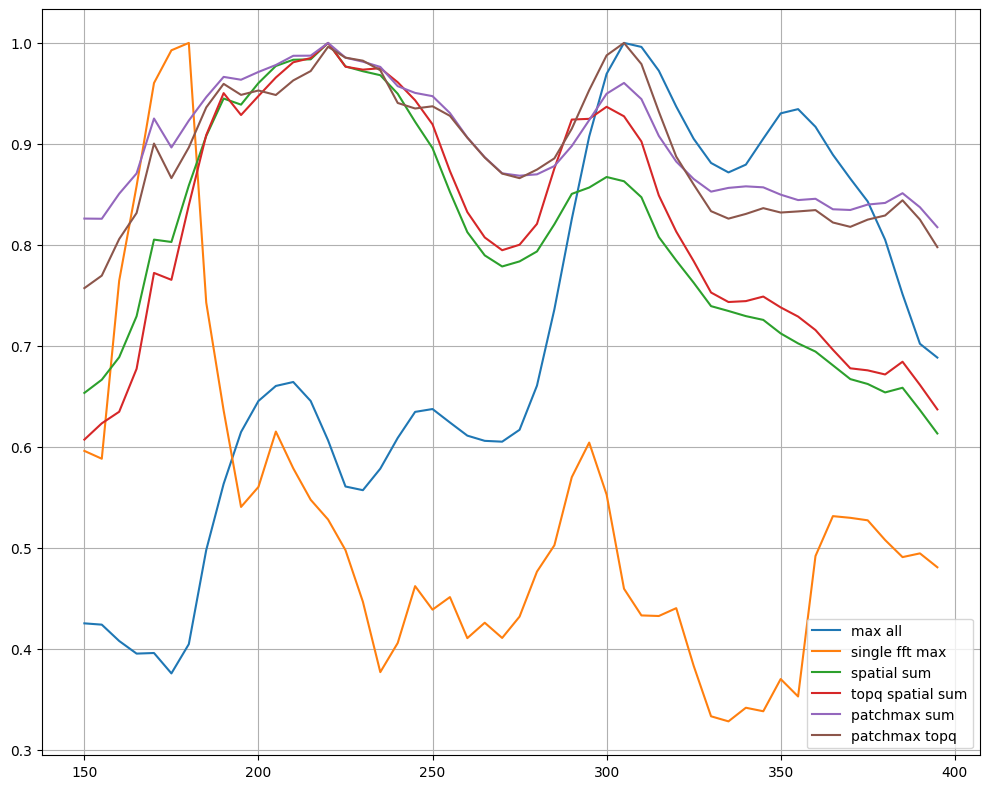

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8), tight_layout=True)
ax.grid(True)
ax.plot(focuser.heights, height_max_all / height_max_all.max(), label="max all")
ax.plot(focuser.heights, baseline / baseline.max(), label="single fft max")
ax.plot(focuser.heights, height_sum_space_maxi_freq / height_sum_space_maxi_freq.max(), label="spatial sum")
ax.plot(focuser.heights, height_sum_topq_space_maxi_freq / height_sum_topq_space_maxi_freq.max(), label="topq spatial sum")
ax.plot(focuser.heights, patchmax_sum / patchmax_sum.max(), label="patchmax sum")
ax.plot(focuser.heights, patchmax_topq / patchmax_topq.max(), label="patchmax topq")
ax.legend()

In [ ]:
wavenum = np.fft.fftfreq(focuser.block_shape[0], focuser.image_maker.hres)
patches = (
    data.isel(time=0).image
    .rolling(y=focuser.block_shape[0], x=focuser.block_shape[1], center=True)
    .construct(x="kx", y="ky", stride=focuser.block_step)
    .isel(x=slice(2,-2), y=slice(2,-2))
    .assign_coords(kx=wavenum, ky=wavenum)
    .rename({"x": "px", "y": "py"})
)
patches.values = fft2(patches * focuser.window)


A = patches.sel(kx=data.isel(time=0).Fx, ky=data.isel(time=0).Fy).values.ravel()
k = np.column_stack((data.isel(time=0).Fx.values.ravel(), data.isel(time=0).Fy.values.ravel()))
px, py = np.meshgrid(data.px, data.py)
pxy = np.column_stack((px.ravel(), py.ravel()))
x, y = np.meshgrid(data.x, data.y)
xy = np.column_stack((x.ravel(), y.ravel()))
r = xy[:, None] - pxy[None]
w = np.zeros(A.shape)
wave = np.sum(A * np.exp(1j * np.sum(r * k[None], axis=-1)), axis=1).reshape(x.shape)
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(12, 5))
plot_patches(data.isel(time=0), ax=ax[0], img=True)
ax[1].pcolormesh(x, y, abs(wave))
plot_patches(data.isel(time=0), ax=ax[1], img=False)

IndexError: Dimensions of indexers mismatch: (slice(None, None, None), slice(None, None, None), <xarray.Variable (py: 8, px: 13)> Size: 832B
array([[ 0,  0,  0,  0, 31, 31,  2, 31,  1,  0,  1,  1,  0],
       [31,  1,  1,  1,  2,  3,  3,  1,  0,  2, 30,  1, 31],
       [ 1,  1,  1,  1,  0,  3,  4, 28,  1,  1,  1,  1,  0],
       [ 0, 31,  0,  0,  1,  0,  3, 31, 30, 30,  1,  0,  0],
       [ 3,  3,  0,  0,  0,  0,  3,  2,  0, 30,  2,  2, 30],
       [ 0,  3,  3,  0, 31, 29, 29,  4,  0,  1,  2,  2,  0],
       [ 0, 29, 30,  2,  2, 30, 29,  4,  0,  1,  1,  3,  1],
       [31, 31,  0,  2,  2,  0,  0,  1,  1, 31,  0,  0,  1]]), <xarray.Variable (py: 8, px: 13)> Size: 832B
array([[0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 1, 2, 1],
       [1, 1, 2, 2, 1, 3, 2, 1, 0, 0, 0, 0, 1],
       [1, 1, 2, 2, 4, 4, 2, 1, 1, 1, 0, 0, 1],
       [3, 0, 1, 2, 4, 4, 2, 0, 0, 1, 0, 0, 1],
       [1, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 1],
       [1, 1, 2, 1, 0, 2, 2, 0, 2, 3, 3, 1, 1],
       [1, 1, 2, 1, 0, 2, 2, 3, 2, 1, 0, 1, 0]]))